This notebook is based on Google codelab's tutorial

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "./input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

sample_submission.csv
test.csv
train.csv



In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf

In [108]:

# read training data from CSV file 
data = pd.read_csv('./input/train.csv')

print('data({0[0]},{0[1]})'.format(data.shape))
print (data.head())


data(42000,785)
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0         0         0   
3       0    ...            0         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0   

In [116]:
images = data.iloc[:,1:]
# convert from [0:255] => [0.0:1.0]
def image_process(df):
    df = df.values.astype(np.float)
    df = np.multiply(df, 1.0 / 255.0)
    df = df.reshape(-1,28,28,1)   
    return df
images = image_process(images)
print images.shape

labels = data.iloc[:,0]
labels_count = np.unique(labels).shape[0]

def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

labels = dense_to_one_hot(labels, labels_count)
labels = labels.astype(np.uint8)
print labels.shape

X_input = np.split(images,len(data)/100)
y_input = np.split(labels,len(data)/100)
print len(X_input)
print len(y_input)


(42000, 28, 28, 1)
(42000, 10)
420
420


In [129]:

# input X: 28x28 grayscale images, the first dimension (None) will index the images in the mini-batch
X = tf.placeholder(tf.float32, [None, 28, 28, 1])
# correct answers will go here
Y_ = tf.placeholder(tf.float32, [None, 10])
# weights W[784, 10]   784=28*28
W = tf.Variable(tf.zeros([784, 10]))
# biases b[10]
b = tf.Variable(tf.zeros([10]))

# flatten the images into a single line of pixels
# -1 in the shape definition means "the only possible dimension that will preserve the number of elements"
XX = tf.reshape(X, [-1, 784])

# The model
Y = tf.nn.softmax(tf.matmul(XX, W) + b)

# loss function: cross-entropy = - sum( Y_i * log(Yi) )
#                           Y: the computed output vector
#                           Y_: the desired output vector

# cross-entropy
# log takes the log of each element, * multiplies the tensors element by element
# reduce_mean will add all the components in the tensor
# so here we end up with the total cross-entropy for all images in the batch
cross_entropy = -tf.reduce_mean(Y_ * tf.log(Y)) * 1000.0  # normalized for batches of 100 images,
                                                          # *10 because  "mean" included an unwanted division by 10
# accuracy of the trained model, between 0 (worst) and 1 (best)
correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
predict = tf.argmax(Y,1)

# training, learning rate = 0.005
train_step = tf.train.GradientDescentOptimizer(0.005).minimize(cross_entropy)

allweights = tf.reshape(W, [-1])
allbiases = tf.reshape(b, [-1])

In [147]:
# init
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [173]:
# You can call this function in a loop to train the model, 100 images at a time
accuracy_list = pd.Series()
def training_step(i,batch_X, batch_Y,accuracy_list):

    # training on batches of 100 images with 100 labels
    #batch_X = X_input.ix[i*100:i*100+100].values
    #batch_Y  = y_input.ix[i*100:i*100+100].values

    # compute training values for visualisation
    if i % 20 == 0:
        a, c, w, b ,co= sess.run([accuracy, cross_entropy, allweights, allbiases,correct_prediction], feed_dict={X: batch_X, Y_: batch_Y})
        print(str(i) + ": accuracy:" + str(a) + " loss: " + str(c))
    #accuracy_list.append(a)
        accuracy_list = accuracy_list.set_value(i, str(a))
    #print str(co)

    # the backpropagation training step
    sess.run(train_step, feed_dict={X: batch_X, Y_: batch_Y})
    
    

In [174]:
for i, (batch_X, batch_Y) in enumerate(zip(X_input, y_input)):
    training_step(i,batch_X, batch_Y,accuracy_list)
    

0: accuracy:0.93 loss: 24.8326
20: accuracy:0.93 loss: 30.1758
40: accuracy:0.94 loss: 24.2318
60: accuracy:0.91 loss: 21.5755
80: accuracy:0.93 loss: 28.7433
100: accuracy:0.97 loss: 18.1682
120: accuracy:0.95 loss: 19.0356
140: accuracy:0.91 loss: 31.3063
160: accuracy:0.92 loss: 34.9279
180: accuracy:0.91 loss: 23.7352
200: accuracy:0.92 loss: 31.4308
220: accuracy:0.92 loss: 32.0196
240: accuracy:0.92 loss: 26.3124
260: accuracy:0.92 loss: 36.2982
280: accuracy:0.91 loss: 31.0324
300: accuracy:0.91 loss: 30.1672
320: accuracy:0.87 loss: 35.4409
340: accuracy:0.92 loss: 29.233
360: accuracy:0.92 loss: 20.3925
380: accuracy:0.87 loss: 32.3913
400: accuracy:0.88 loss: 42.5342


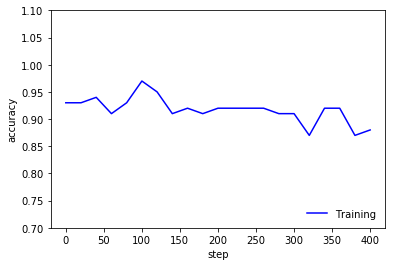

In [180]:
# check final accuracy on validation set  
VALIDATION_SIZE = 2000
if(VALIDATION_SIZE):
    #validation_accuracy = accuracy.eval(image)
    #print('training_accruacy => %.4f'%accuracy_list)
    #print('validation_accuracy => %.4f'%validation_accuracy)
    plt.plot( accuracy_list,'-b', label='Training')
    #plt.plot(x_range, validation_accuracies,'-g', label='Validation')
    plt.legend(loc='lower right', frameon=False)
    plt.ylim(ymax = 1.1, ymin = 0.7)
    plt.ylabel('accuracy')
    plt.xlabel('step')
    plt.show()

In [178]:
accuracy_list

0      0.93
20     0.93
40     0.94
60     0.91
80     0.93
100    0.97
120    0.95
140    0.91
160    0.92
180    0.91
200    0.92
220    0.92
240    0.92
260    0.92
280    0.91
300    0.91
320    0.87
340    0.92
360    0.92
380    0.87
400    0.88
dtype: object

In [159]:
accuracy.eval(session=sess)

InvalidArgumentError: Shape [-1,28,28,1] has negative dimensions
	 [[Node: Placeholder_16 = Placeholder[dtype=DT_FLOAT, shape=[?,28,28,1], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op u'Placeholder_16', defined at:
  File "/Users/crisliu/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/crisliu/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/crisliu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/crisliu/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/crisliu/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Users/crisliu/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/crisliu/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/crisliu/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/crisliu/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/crisliu/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/crisliu/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/crisliu/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/crisliu/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/crisliu/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/crisliu/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/crisliu/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/crisliu/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/crisliu/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/crisliu/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/crisliu/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-129-7f0605648f66>", line 3, in <module>
    X = tf.placeholder(tf.float32, [None, 28, 28, 1])
  File "/Users/crisliu/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/array_ops.py", line 1530, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "/Users/crisliu/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1954, in _placeholder
    name=name)
  File "/Users/crisliu/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/Users/crisliu/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/crisliu/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Shape [-1,28,28,1] has negative dimensions
	 [[Node: Placeholder_16 = Placeholder[dtype=DT_FLOAT, shape=[?,28,28,1], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [150]:
data2 = pd.read_csv('./input/test.csv')
print('data2({0[0]},{0[1]})'.format(data2.shape))
test_image = image_process(data2)
print test_image.shape

data2(28000,784)
(28000, 28, 28, 1)


In [153]:
predicted_labels = sess.run(predict, feed_dict={X: test_image})

In [155]:
pd.Series(predicted_labels).value_counts()

1    3313
4    2961
3    2934
9    2873
0    2785
8    2741
7    2734
6    2716
2    2589
5    2354
dtype: int64

In [157]:
np.c_[range(1,len(test_image)+1),predicted_labels]

array([[    1,     2],
       [    2,     0],
       [    3,     9],
       ..., 
       [27998,     3],
       [27999,     9],
       [28000,     2]])

In [30]:

from tensorflow.examples.tutorials.mnist import input_data as mnist_data
mnist = mnist_data.read_data_sets("data", one_hot=True, reshape=False, validation_size=0)
batch_X, batch_Y = mnist.train.next_batch(100)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [66]:
def training_step(i, update_test_data, update_train_data):

    # training on batches of 100 images with 100 labels
    batch_X, batch_Y = mnist.train.next_batch(100)

    # compute training values for visualisation
    #if update_train_data:
    a, c,  w, b = sess.run([accuracy, cross_entropy,  allweights, allbiases], feed_dict={X: batch_X, Y_: batch_Y})
        #datavis.append_training_curves_data(i, a, c)
        #datavis.append_data_histograms(i, w, b)
        #datavis.update_image1(im)
    print(str(i) + ": accuracy:" + str(a) + " loss: " + str(c))

    # compute test values for visualisation
    #if update_test_data:
        #a, c = sess.run([accuracy, cross_entropy], feed_dict={X: mnist.test.images, Y_: mnist.test.labels})
        #datavis.append_test_curves_data(i, a, c)
        #datavis.update_image2(im)
        #print(str(i) + ": ********* epoch " + str(i*100//mnist.train.images.shape[0]+1) + " ********* test accuracy:" + str(a) + " test loss: " + str(c))

    # the backpropagation training step
    sess.run(train_step, feed_dict={X: batch_X, Y_: batch_Y})

In [67]:
for i in range(2000+1): training_step(i, i % 50 == 0, i % 10 == 0)

0: accuracy:0.07 loss: 230.259
1: accuracy:0.18 loss: 197.406
2: accuracy:0.39 loss: 197.469
3: accuracy:0.49 loss: 161.231
4: accuracy:0.49 loss: 146.902
5: accuracy:0.71 loss: 121.839
6: accuracy:0.66 loss: 105.253
7: accuracy:0.67 loss: 109.099
8: accuracy:0.58 loss: 122.325
9: accuracy:0.61 loss: 103.686
10: accuracy:0.76 loss: 78.3923
11: accuracy:0.74 loss: 85.1512
12: accuracy:0.78 loss: 83.0243
13: accuracy:0.74 loss: 84.6853
14: accuracy:0.83 loss: 73.4402
15: accuracy:0.78 loss: 73.8648
16: accuracy:0.84 loss: 72.4589
17: accuracy:0.78 loss: 71.3525
18: accuracy:0.82 loss: 67.7167
19: accuracy:0.78 loss: 70.3038
20: accuracy:0.84 loss: 60.6919
21: accuracy:0.79 loss: 61.8259
22: accuracy:0.81 loss: 62.2855
23: accuracy:0.86 loss: 56.7555
24: accuracy:0.82 loss: 66.6529
25: accuracy:0.85 loss: 66.7546
26: accuracy:0.85 loss: 47.9472
27: accuracy:0.86 loss: 54.4692
28: accuracy:0.86 loss: 49.7939
29: accuracy:0.91 loss: 44.6135
30: accuracy:0.86 loss: 50.7238
31: accuracy:0.81 

In [63]:
print("max test accuracy: " + str(datavis.get_max_test_accuracy()))

NameError: name 'datavis' is not defined